# Fractional, aliasing downsampler

My project for 267 is to write a real-time, fractional, aliasing downsampler. A non-aliasing downsampler can be trivally emulated with a low-pass filter. An aliasing downsampler however requires going through the motions of interpolating and decimating. The general outline of the algorithm is as follows:

* Original sample rate fso
* Specify some new fsn
* Find some A and B out of a finite set of integers such that A / B closely approximates fsn / fso
* Upsample the signal by a factor of A (insert A-1 zeros between original samples)
* Interpolate the upsampled signal with a low-pass with cutoff (fso * A) / 2.0 
* Downsample the signal by a factor of B (keep 1 sample remove B-1). This is where the aliasing happens
* Upsample the signal by a factor of B (insert B-1 zeros between original samples)
* Interpolate the re-upsampled signal with a low-pass with cutoff (fsn * B) / 2.0
* Downsample the signal by a factor of A (keep 1 sample remove A-1)
* We now have the aliased signal with Nyquist fsn / 2.0 back at the original sample rate fso

I will design an array of N-order Butterworth filters, tweaking N to a value that can be handled by the STM32F4, to perform the interpolation. Conveniently, fractional resampling requires rational approximation via integers to handle interpolation/decimation. This means we can design a finite number of filters offline and load the coefficients into the C code.

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


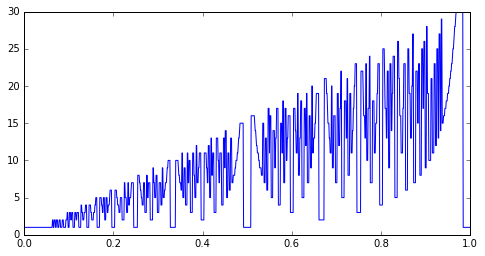

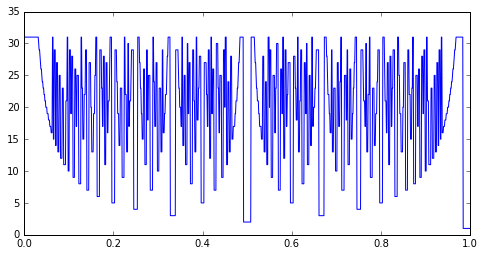

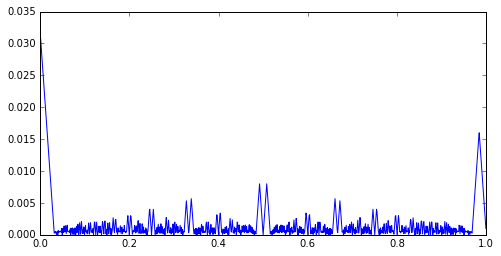

In [30]:
# This function takes a real ratio (e.g. 0.33333) and finds a rational approximation from a set of integers (e.g. 1/3)

def rationalize_real(ratio, A=[0, 1, 2, 3, 4, 5, 6, 7, 8], B=[1, 2, 3, 4, 5, 6, 7, 8]):
    closest = (None, None)
    for a in A:
        for b in B:
            if a > b:
                pass
            ratio_approx = float(a) / b
            error = abs(ratio_approx - ratio)
            if closest[0] is None or error < closest[0]:
                closest = (error, (a, b))
    return closest[1]

block_size = 16
rats = np.arange(0.0, 1.0, 0.001)
nums = []
dens = []
errs = []
ranges = []
for rat in rats:
    a, b = rationalize_real(rat, A=range(1, 32), B=range(1, 32))
    error = abs((float(a) / b) - rat)
    errs.append(error)
    nums.append(a)
    dens.append(b)
plt.figure(figsize=(8, 4))
plt.plot(rats, nums)
plt.figure(figsize=(8, 4))
plt.plot(rats, dens)
plt.figure(figsize=(8, 4))
plt.plot(rats, errs)

16
30


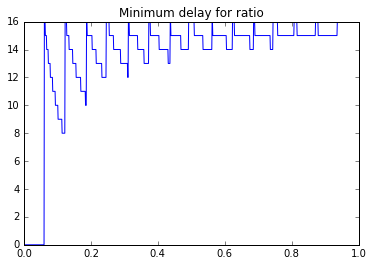

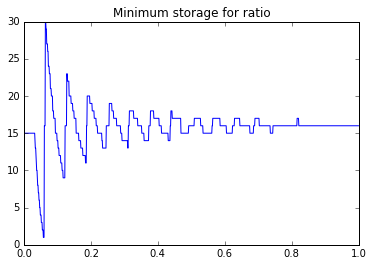

In [33]:
import math

n = 16

def calc_block_range(n, m, l):
    n = float(n)
    m = float(m)
    l = float(l)
    
    floor = lambda x: math.floor(x)
    ceil = lambda x: math.ceil(x)
    
    orig = [n, n]
    up = [m * orig[0], m * orig[1]]
    down = [floor(up[0] / l), ceil(up[1] / l)]
    reup = [l * down[0], l * down[1]]
    redown = [floor(reup[0] / m), ceil(reup[1] / m)]
    return int(redown[0]), int(redown[1])

minimum_delays = []
minimum_storage = []
for rat in rats:
    a, b = rationalize_real(rat, A=range(1, 16), B=range(1, 32))
    block_range = calc_block_range(n, a, b)
    minimum_delays.append(block_range[0])
    minimum_storage.append(block_range[1] - n + block_range[0])

print np.max(minimum_delays)
plt.figure()
plt.plot(rats, minimum_delays)
plt.title('Minimum delay for ratio')

print np.max(minimum_storage)
plt.figure()
plt.title('Minimum storage for ratio')
plt.plot(rats, minimum_storage)

0.181818181818
8018.18181818


(1000, 8000)

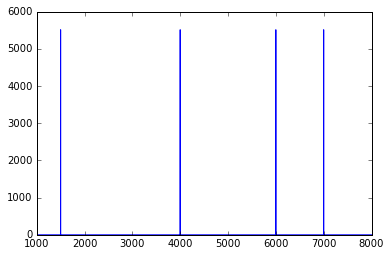

In [3]:
# Create test signal with 4 sinusoids at 44100.0

fso = 44100.0
fsn_ideal = 8000.0
f = [1500.0, 4000.0, 6000.0, 7000.0]
lens = 1.0

upsample, downsample = rationalize_real(fsn_ideal / fso, A=range(0, 100), B=range(1, 100))
ratio = upsample / float(downsample)
fsn = fso * ratio
print ratio
print fsn
f = np.array(f)[:, np.newaxis]

t = np.arange(0.0, lens, 1.0 / fso)[:, np.newaxis]
xarr = np.sin(2.0 * np.pi * f * t.T)
x = np.sum(xarr, axis=0)
x /= len(f)

plt.plot(np.abs(np.fft.rfft(x)))
plt.xlim(1000, 8000)

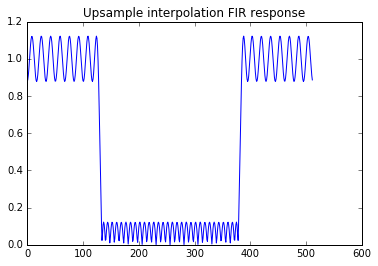

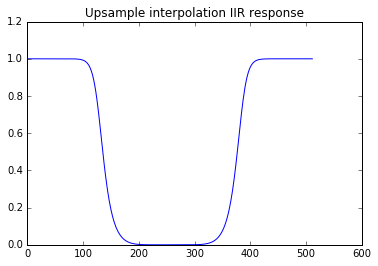

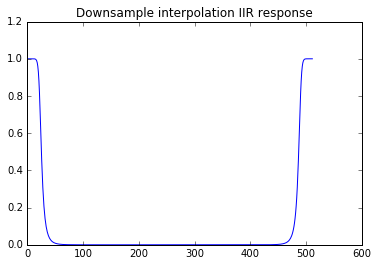

In [4]:
# Design some interpolation FIR and IIR filters

from scipy.signal import remez, iirfilter, freqz

cutoff = 0.5 / upsample
tolerance = 0.01

finterp_fir = remez(64, [0, cutoff, cutoff + tolerance, 0.5], [1.0, 0.0])
finterp_iir_b, finterp_iir_a = iirfilter(6, cutoff * 2, btype='lowpass', ftype='butter')

freq, response = freqz(finterp_fir, whole=True)
ampl = np.abs(response)
plt.figure()
plt.title('Upsample interpolation FIR response')
plt.plot(ampl)

freq, response = freqz(finterp_iir_b, finterp_iir_a, whole=True)
ampl = np.abs(response)
plt.figure()
plt.title('Upsample interpolation IIR response')
plt.plot(ampl)

fup_iir_b, fup_iir_a = iirfilter(6, 1.0 / downsample, btype='lowpass', ftype='butter')

freq, response = freqz(fup_iir_b, fup_iir_a, whole=True)
ampl = np.abs(response)
plt.figure()
plt.title('Downsample interpolation IIR response')
plt.plot(ampl)

2 11
(44100L,)
(88200L,)
(88209L,)
(8019L,)
(88209L,)
(88210L,)
(44105L,)


(0, 50.0)

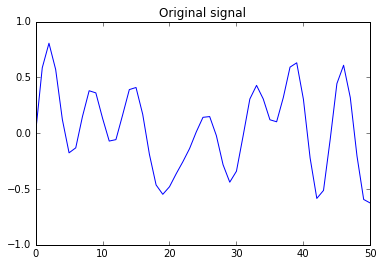

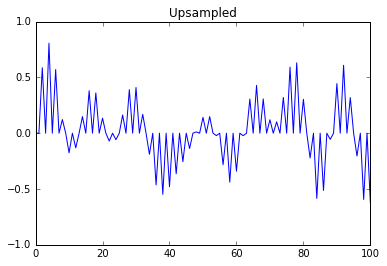

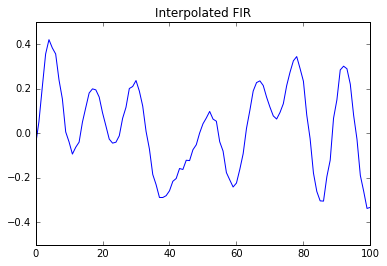

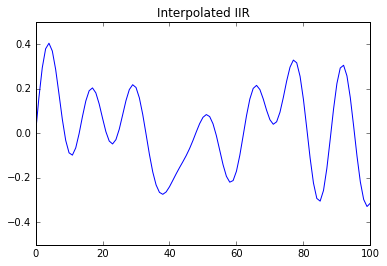

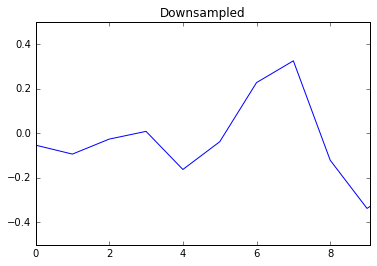

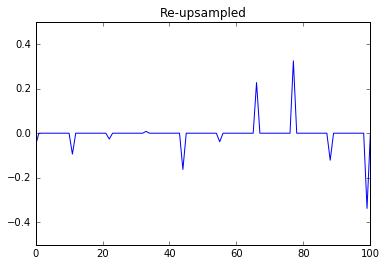

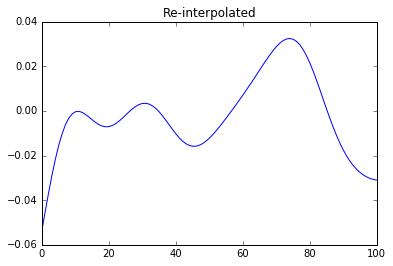

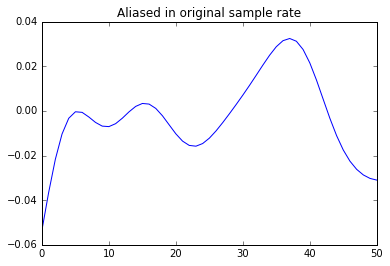

In [6]:
# Perform algorithm on test signal

from scipy.signal import fftconvolve, lfilter, filtfilt

print upsample, downsample
print x.shape

plt.figure()
plt.title('Original signal')
plt.plot(x)
plt.xlim([0, 100.0 / upsample])

xup = np.zeros((upsample, x.shape[0]))
xup[0] = x
xup = xup.T.flatten()
print xup.shape

plt.figure()
plt.title('Upsampled')
plt.plot(xup)
plt.xlim([0, 100])

xinterp = fftconvolve(xup, finterp_fir, mode='same')
remaining = xinterp.shape[0] % downsample
if remaining > 0:
    xinterp = np.concatenate([xinterp, np.zeros(downsample - remaining, dtype=np.float64)])
print xinterp.shape

plt.figure()
plt.title('Interpolated FIR')
plt.plot(xinterp)
plt.xlim([0, 100])

xinterp_iir = filtfilt(finterp_iir_b, finterp_iir_a, xup)

plt.figure()
plt.title('Interpolated IIR')
plt.plot(xinterp_iir)
plt.xlim([0, 100])

xdown = np.reshape(xinterp, (-1, downsample))[:, 0]
print xdown.shape

plt.figure()
plt.title('Downsampled')
plt.plot(xdown)
plt.xlim([0, 100.0 / downsample])

xreup = np.zeros((downsample, xdown.shape[0]))
xreup[0] = xdown
xreup = xreup.T.flatten()
print xreup.shape

plt.figure()
plt.title('Re-upsampled')
plt.plot(xreup)
plt.xlim([0, 100.0])

xreup_interp = filtfilt(fup_iir_b, fup_iir_a, xreup)
remaining = xreup_interp.shape[0] % upsample
if remaining > 0:
    xreup_interp = np.concatenate([xreup_interp, np.zeros(upsample - remaining, dtype=np.float64)])
print xreup_interp.shape

plt.figure()
plt.title('Re-interpolated')
plt.plot(xreup_interp)
plt.xlim([0, 100.0])

xrecons = np.reshape(xreup_interp, (-1, upsample))[:, 0]
print xrecons.shape

plt.figure()
plt.title('Aliased in original sample rate')
plt.plot(xrecons)
plt.xlim([0, 50.0])

(0, 8000)

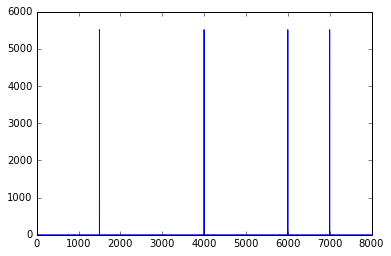

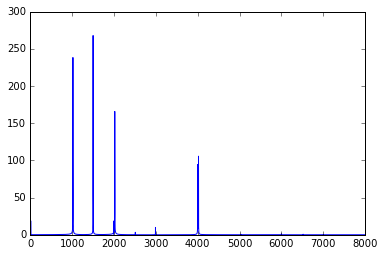

In [7]:
# Plot magnitudes of original and aliased signals. Sinusoids should be mirrored around fsn/2.0 if they exceed it

plt.figure()
plt.plot(np.fft.rfftfreq(x.shape[0], 1.0 / fso), np.abs(np.fft.rfft(x)))
plt.xlim([0, 8000])
plt.figure()
plt.plot(np.fft.rfftfreq(xrecons.shape[0], 1.0 / fso), np.abs(np.fft.rfft(xrecons)))
plt.xlim([0, 8000])

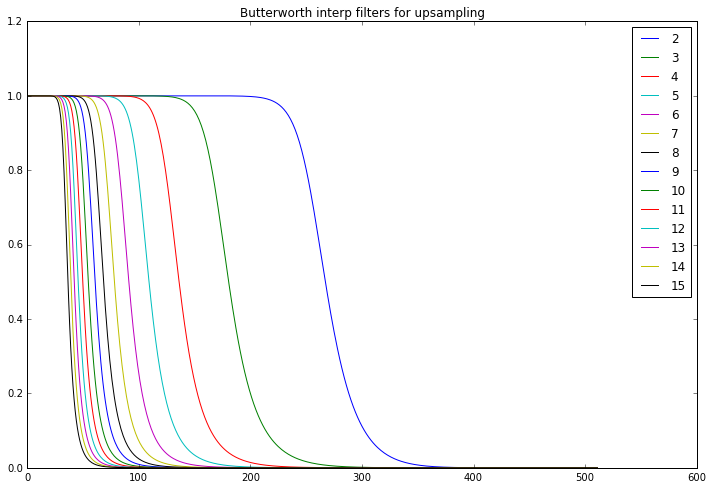

In [8]:
# Plot the response of Butterworth filters for various interpolation amounts

order = 8
max_upsample = 16

plt.figure(figsize=(12, 8))
plt.title('Butterworth interp filters for upsampling')
for i in xrange(2, max_upsample):
    iir_b, iir_a = iirfilter(order, 1.0 / i, btype='lowpass', ftype='butter')
    
    _, response = freqz(iir_b, iir_a)
    ampl = np.abs(response)
    plt.plot(ampl, label=str(i))
plt.legend()

In [9]:
# Create C code for static filter coefficient tables

iir_b = np.zeros((max_upsample, order + 1), dtype=np.float64)
iir_a = np.zeros((max_upsample, order + 1), dtype=np.float64)

for i in xrange(2, max_upsample):
    b, a = iirfilter(order, 1.0 / i, btype='lowpass', ftype='butter')
    iir_b[i] = b
    iir_a[i] = a

out_txt = 'const float* butter_interp_b[{}] = {{'.format((max_upsample - 2 - 1) * (order + 1))
for i in xrange(2, max_upsample):
    b_str = ['{:.8f}f'.format(x) for x in iir_b[i]]
    out_txt += '\n' +  ', '.join(b_str)
    if i != max_upsample - 1:
        out_txt += ','
    out_txt += ' \t// {}'.format(i)
out_txt += '\n}'

print out_txt

out_txt = 'const float* butter_interp_a[{}] = {{'.format((max_upsample - 2 - 1) * (order + 1))
for i in xrange(2, max_upsample):
    b_str = ['{:.8f}f'.format(x) for x in iir_a[i]]
    out_txt += '\n' +  ', '.join(b_str)
    if i != max_upsample - 1:
        out_txt += ','
    out_txt += ' \t// {}'.format(i)
out_txt += '\n}'

print out_txt

const float* butter_interp_b[117] = {
0.00926729f, 0.07413828f, 0.25948400f, 0.51896799f, 0.64870999f, 0.51896799f, 0.25948400f, 0.07413828f, 0.00926729f, 	// 2
0.00070924f, 0.00567392f, 0.01985871f, 0.03971742f, 0.04964678f, 0.03971742f, 0.01985871f, 0.00567392f, 0.00070924f, 	// 3
0.00010791f, 0.00086329f, 0.00302152f, 0.00604303f, 0.00755379f, 0.00604303f, 0.00302152f, 0.00086329f, 0.00010791f, 	// 4
0.00002396f, 0.00019168f, 0.00067087f, 0.00134174f, 0.00167718f, 0.00134174f, 0.00067087f, 0.00019168f, 0.00002396f, 	// 5
0.00000680f, 0.00005444f, 0.00019053f, 0.00038106f, 0.00047633f, 0.00038106f, 0.00019053f, 0.00005444f, 0.00000680f, 	// 6
0.00000230f, 0.00001842f, 0.00006446f, 0.00012892f, 0.00016115f, 0.00012892f, 0.00006446f, 0.00001842f, 0.00000230f, 	// 7
0.00000089f, 0.00000711f, 0.00002487f, 0.00004974f, 0.00006217f, 0.00004974f, 0.00002487f, 0.00000711f, 0.00000089f, 	// 8
0.00000038f, 0.00000304f, 0.00001063f, 0.00002126f, 0.00002658f, 0.00002126f, 0.00001063f, 0.00000304